In [ ]:
%%capture
!pip install tensorflow_text
!git clone https://github.com/Jmkernes/PAR-Transformer-XL.git
%cd PAR-Transformer-XL/

In [ ]:
%load_ext autoreload
%autoreload 2

In [613]:
import logging
logging.info("\n\n~~~~~~~~ Importing Modules ~~~~~~~~\n")

import os
import time
import datetime
import numpy as np
import tensorflow as tf
import tensorflow_text as tf_text
import matplotlib.pyplot as plt
from data_utils import DataManager
from utils import print_bar, visualize_pi_weights
from par_model import PARTransformerXL
from par_model import create_lookahead_mask, positional_encoding

tf.debugging.enable_check_numerics()
tf.autograph.set_verbosity(0)

def load_datasets(train, val, test):
    """Load the wikitext2 train, validation and test data"""
    logging.info(f"\nLoading training data from: {train}")
    config = {'tfrecords_directory': train,'sp_model_prefix': 'wiki2_12k'}
    train_dm = DataManager.initialize_from_tfrecord(config)

    logging.info(f"\nLoading validation data from: {val}")
    config['tfrecords_directory'] = val
    valid_dm = DataManager.initialize_from_tfrecord(config)

    logging.info(f"\nLoading testing data from: {test}\n")
    config['tfrecords_directory'] = test
    test_dm = DataManager.initialize_from_tfrecord(config)

    return train_dm, valid_dm, test_dm

class TransformerSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000, **kwargs):
        super().__init__(**kwargs)
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

class CosineSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, max_lr, decay_steps, warmup_steps=4000, **kwargs):
        super().__init__(**kwargs)
        self.max_lr = max_lr
        self.decay_steps = decay_steps
        self.warmup_steps = warmup_steps
        self.pi = 3.1415927
    def __call__(self, step):
        linear = self.max_lr*(step/self.warmup_steps)
        cosine = 0.5*self.max_lr*(1+tf.math.cos(self.pi*tf.math.maximum(step-self.warmup_steps, 0)/self.decay_steps))
        return tf.math.minimum(linear, cosine)    

INFO:tensorflow:Enabled check-numerics callback in thread MainThread


INFO:tensorflow:Enabled check-numerics callback in thread MainThread


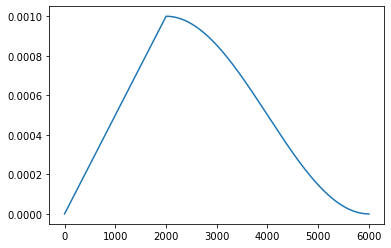

In [614]:
learning_rate = CosineSchedule(1e-3, 4000, 2000)
plt.plot(learning_rate(tf.range(6000.)))

In [615]:
# checkpointing and tensorboard params
model_name='base'#datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# data params
train_directory='data/wikitext2_bsz32_seqlen32_tfrecords_train'
valid_directory='data/wikitext2_bsz32_seqlen32_tfrecords_valid'
test_directory='data/wikitext2_bsz32_seqlen32_tfrecords_test'

# model params
d_model=256
num_heads=8
d_ffn=1024
num_layers=12
mem_len=32
dropout_rate=0.1
cutoffs=[250, 2500]
proj_factor=4
proj_dims=[]

# small version for testing
# d_model=64
# num_heads=2
# d_ffn=128
# num_layers=4
# mem_len=32
# dropout_rate=0.1
# cutoffs=[250, 2500]
# proj_factor=2
# proj_dims=[]

# learning params
warmup_steps=4000
tau_start=2.0
tau_end=0.2
epochs=5
tau_is_trainable=False
opt_name='adam'

In [662]:
# Take care of some flags logic beyond simple constraints.
if d_model%num_heads:
    raise ValueError('Number of heads must divide d_model')

train_dm, valid_dm, test_dm = load_datasets(train_directory, valid_directory, test_directory)

## Set global constants inferred from the training data.
BATCH_SIZE = train_dm.batch_size
SEQ_LEN = train_dm.seq_len
VOCAB_SIZE = train_dm.tokenizer.vocab_size().numpy()
DATASET_SIZE = train_dm.ds_size.numpy()
MAX_POSITION = max(512, mem_len+SEQ_LEN)

# Take care of additional constraints on inputs that needed the vocab size
if any([z>=VOCAB_SIZE for z in cutoffs]) or len(set(cutoffs))!=len(cutoffs):
    raise ValueError("Cutoffs must not exceed {VOCAB_SIZE} or contain duplicates.")
if cutoffs:
    cutoffs.sort()
    cutoffs.append(VOCAB_SIZE)

### Define learning rate schedule and simulated annealing schedule for gumbel softmax temperature tau.
logging.info(f"\n\nInitializing {opt_name} optimizer with {warmup_steps} warmup steps.")
learning_rate = CosineSchedule(max_lr=5e-4, warmup_steps=4000, decay_steps=DATASET_SIZE*epochs-4000)
optimizer = tf.keras.optimizers.get(opt_name)
optimizer.learning_rate = learning_rate

if tau_is_trainable:
    logging.info(f"\n\nInitializing exponential tau decay: {tau_start}-->{tau_end}.\n")
tau = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=tau_start,
    decay_steps=DATASET_SIZE*epochs,
    decay_rate=tau_end
)

In [661]:
# Setup the model
tf.keras.backend.clear_session()
config = {
    'd_model': d_model,
    'num_heads': num_heads,
    'max_position': MAX_POSITION,
    'd_ffn': d_ffn,
    'num_layers': num_layers,
    'mem_len': mem_len,
    'vocab_size': VOCAB_SIZE,
    'dropout_rate': dropout_rate,
    'cutoffs': cutoffs,
    'proj_factor': proj_factor,
    'proj_dims': proj_dims,
}
logging.info("\n\nInitializing model...")
logging.info("Model parameters:")
logging.info(config)
pos_enc = positional_encoding(MAX_POSITION, d_model)
lookahead_mask = create_lookahead_mask(MAX_POSITION, MAX_POSITION)
model = PARTransformerXL(**config)

# Build model by feeding in sample training data
x_temp, y_temp = next(iter(train_dm.get_inp_tar_pairs()))
model(x_temp, None, labels=y_temp, training=False)

# make tau untrainable
if not tau_is_trainable:
    for layer in model.layers:
        if hasattr(layer, 'tau'):
            layer.tau = tf.cast(tf.constant(1.), tf.float32)

In [618]:
# print out model summary
logging.info("\nModel summary:")
logging.info(model.summary())

# Define metrics
train_loss = tf.keras.metrics.Mean()
valid_loss = tf.keras.metrics.Mean()
train_perp = tf.keras.metrics.Mean()
valid_perp = tf.keras.metrics.Mean()

logging.info("\n\nDefining training and evaluation steps...")
# Define the training and evaluation steps via tf functions
@tf.function
def train_step(inp, x_mems, labels, tau):
    with tf.GradientTape() as tape:
        loss, mems = model(inp, x_mems=x_mems, labels=labels, training=True, tau=tau)
    grads = tape.gradient(loss, model.trainable_variables)
    grads = [tf.clip_by_norm(g, 0.1) for g in grads]
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    train_loss(loss)
    train_perp(tf.math.exp(loss))
    return mems

@tf.function
def evaluation_step(x, x_mems, labels, tau):
    loss, mems = model(x, x_mems=x_mems, labels=labels, tau=tau, training=False)
    valid_loss(loss)
    valid_perp(tf.math.exp(loss))
    return mems

def evaluation(dataset, tau):
    x_mems = None
    for x, lbl in dataset:
        x_mems = evaluation_step(x, x_mems, lbl, tau)

Model: "par_transformer_xl"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  768000    
_________________________________________________________________
adaptive_softmax (AdaptiveSo multiple                  255250    
_________________________________________________________________
stochastic_block (Stochastic multiple                  37763     
_________________________________________________________________
stochastic_block_1 (Stochast multiple                  37763     
_________________________________________________________________
stochastic_block_2 (Stochast multiple                  37763     
_________________________________________________________________
stochastic_block_3 (Stochast multiple                  37763     
_________________________________________________________________
inp_dropout (Dropout)        multiple           

In [660]:
# Set up TensorBoard
logging.info("\n\nInitializing TensorBoard...")
train_log_dir = './logs/' + model_name + '/train'
test_log_dir = './logs/' + model_name + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

# load tensorboard using in-notebook command
%load_ext tensorboard
%tensorboard --logdir logs

# Configure datasets for training
logging.info("\n\nConfiguring datasets for training. Caching, prefetching...")
glob_step = tf.Variable(0, dtype=tf.int64) # This will break tf.summary if we use int32
train_ds = train_dm.get_inp_tar_pairs().cache().prefetch(tf.data.AUTOTUNE)
valid_ds = valid_dm.get_inp_tar_pairs().prefetch(tf.data.AUTOTUNE)
iterator=iter(train_ds)

# Set up checkpointing to periodically save the model every epoch
checkpoint_path = "./checkpoints/train/"+model_name
logging.info(f"\n\nInitializing checkpoints. Models will be saved to {checkpoint_path}")
ckpt = tf.train.Checkpoint(
    model=model,
    optimizer=optimizer,
    glob_step=glob_step,
    iterator=iterator
)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    try:
        ckpt.restore(ckpt_manager.latest_checkpoint)
        logging.info('Latest checkpoint restored!!')
    except:
        logging.warning("Model may have changed, could not restore checkpoint.")

In [620]:
# log initial checkpoint
ckpt_save_path = ckpt_manager.save()

In [624]:
# Run the actual training loop!
logging.info("\n\n~~~~~~~~~~ Beginning training ~~~~~~~~~~")
for epoch in range(epochs):

#     logging.info('-'*10+f' Epoch {epoch+1}/{epochs} '+'-'*10)
    print('-'*10+f' Epoch {epoch+1}/{epochs} '+'-'*10)
    start = time.time()
    for x in [train_loss, valid_loss, train_perp, valid_perp]:
        x.reset_states()
    mems = None

    for step, (inp, lbl) in enumerate(train_ds:

        mems = train_step(inp, mems, lbl, tau(glob_step))

        diff = (time.time()-start)/(step+1)
        print_bar(step, DATASET_SIZE, diff, train_loss.result().numpy())

        with train_summary_writer.as_default():
            tf.summary.scalar('train_loss', train_loss.result(), step=glob_step)
            tf.summary.scalar('train_perp', train_perp.result(), step=glob_step)
            tf.summary.scalar('tau', tau(glob_step), step=glob_step)
        glob_step.assign_add(1)

    evaluation(valid_ds, tau(glob_step))
    with test_summary_writer.as_default():
        tf.summary.scalar('valid_loss', valid_loss.result(), step=glob_step)
        tf.summary.scalar('valid_perp', valid_perp.result(), step=glob_step)

    ckpt_save_path = ckpt_manager.save()
    logging.info(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')
    
    visualize_pi_weights(model)
    plt.show()

---------- Epoch 1/5 ----------
Iteration 50/50: [==========>] 4.45 it/s. Est: 00m 00s Loss: 8.261
---------- Epoch 2/5 ----------
Iteration 50/50: [==========>] 3.70 it/s. Est: 00m 00s Loss: 8.177
---------- Epoch 3/5 ----------
Iteration 50/50: [==========>] 3.64 it/s. Est: 00m 00s Loss: 8.053
---------- Epoch 4/5 ----------
Iteration 50/50: [==========>] 3.71 it/s. Est: 00m 00s Loss: 7.865
---------- Epoch 5/5 ----------
Iteration 50/50: [==========>] 3.87 it/s. Est: 00m 00s Loss: 7.647


In [667]:
# load in a model from checkpoint
if False:
    new_model = PARTransformerXL(**config)
    new_model.build(input_shape=[32, 32])
    # make tau untrainable
    if not tau_is_trainable:
        for layer in new_model.layers:
            if hasattr(layer, 'tau'):
                layer.tau = tf.cast(tf.constant(1.), tf.float32)
    ckpt = tf.train.Checkpoint(
        model=new_model
    )
    ckpt.restore(ckpt_manager.latest_checkpoint)

    for i in range(len(model.weights)):
        bl tf.experimental.numpy.allclose(
            new_model.weights[i], model.weights[i])
        print(f"Weights {i}: {bl}")

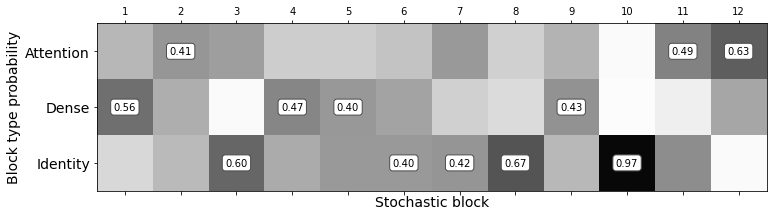

In [771]:
weights = np.random.rand(12, 3)
weights /= np.sum(weights, -1, keepdims=True)
_, _ = stochastic_block_plot(weights)

In [758]:
from  import stochastic_block_plot